<a href="https://colab.research.google.com/github/swapnafelix/Plant_seeding_classification/blob/master/seeding_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install fastai2
# !pip install fastai2 -q

In [2]:
#data is from google drive. Import data and save in a file data_zip
# data_zip = '/content/drive/My Drive/Plant_seeding_classification/plant-seedlings-classification.zip'

In [3]:
#print data_zip to check our file
# data_zip

In [4]:
#unzip the data and save that in a folder called data. 
#data folder has training and test set. 

# !unzip -q '/content/drive/My Drive/Plant_seeding_classification/plant-seedlings-classification.zip' -d data 


In [1]:
#import fastai library
from fastai2.vision.all import  *

In [2]:
#get training folder and change that into Path and save that. 
path = Path('/content/data/train')
#List the contents of train folder.
path.ls()

(#13) [Path('/content/data/train/Sugar beet'),Path('/content/data/train/Common Chickweed'),Path('/content/data/train/Cleavers'),Path('/content/data/train/Common wheat'),Path('/content/data/train/Scentless Mayweed'),Path('/content/data/train/Black-grass'),Path('/content/data/train/Fat Hen'),Path('/content/data/train/Maize'),Path('/content/data/train/Charlock'),Path('/content/data/train/models')...]

In [7]:
#train folder has sub folders - intotal 12. This is the number of classes we are classifying. 
#each plant category is in separate folder. 

In [3]:
#batch size - this is the number of images we are processing at a time
bs = 64
np.random.seed(32)
#define item transofrm - in this we crop the image for a batch transformation
item_tfms = RandomResizedCrop(360, min_scale=0.75, ratio=(1.,1.))
#define batch transformation - this crop and augument image for processing. 
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [4]:
#creata a dataloader for image processing
dls = ImageDataLoaders.from_folder(path, valid_pct = 0.2, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=bs, shuffle_train=True)

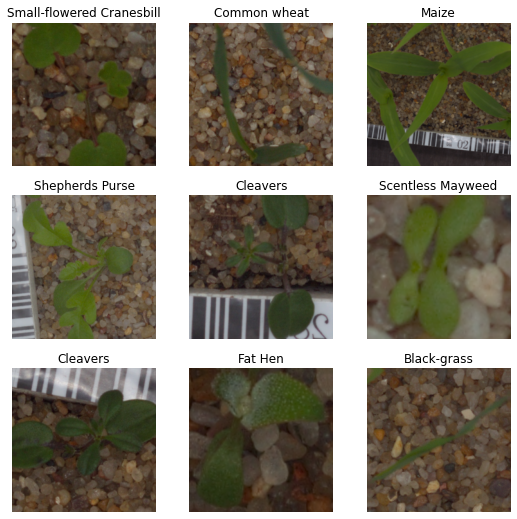

In [5]:
#print the input images to see how it looks
dls.show_batch()

In [6]:
#print number of classes in our input data. 
dls.c

12

In [7]:
"""#create a learner - learn.I use resnet34 as my cnn learner. In this step I use the resnet34 - which is a pretrained model for cnn.
The metrics used is accuracy - to check the accuracy of our model.
"""
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [8]:
#run the model 6 epochs
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,2.727589,1.126254,0.622105,01:01
1,1.430975,0.477974,0.833684,01:02
2,0.822458,0.353075,0.883158,01:02
3,0.550910,0.302649,0.896842,01:02
4,0.420628,0.272109,0.907368,01:02
5,0.358855,0.272378,0.904211,01:02


In [9]:
#save the model so that we can use it to thsi stage later on.
learn.save('resnet34_1')

In [10]:
#In this step we create an interpretation of our model to know more about our model. 
# we can use interp to print confusion matrix and understand the losses of our model.
interp = ClassificationInterpretation.from_learner(learn)

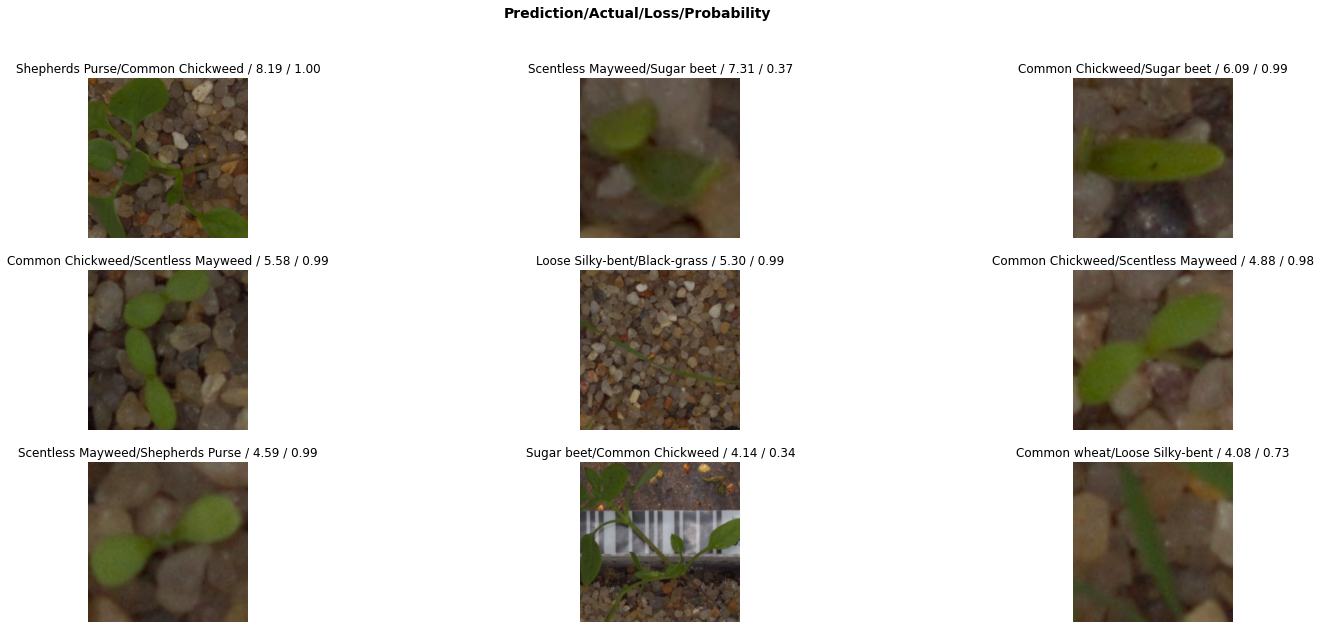

In [11]:
#plot top losses to see which are items we misclassifed. 
interp.plot_top_losses(9, figsize = (25, 10))

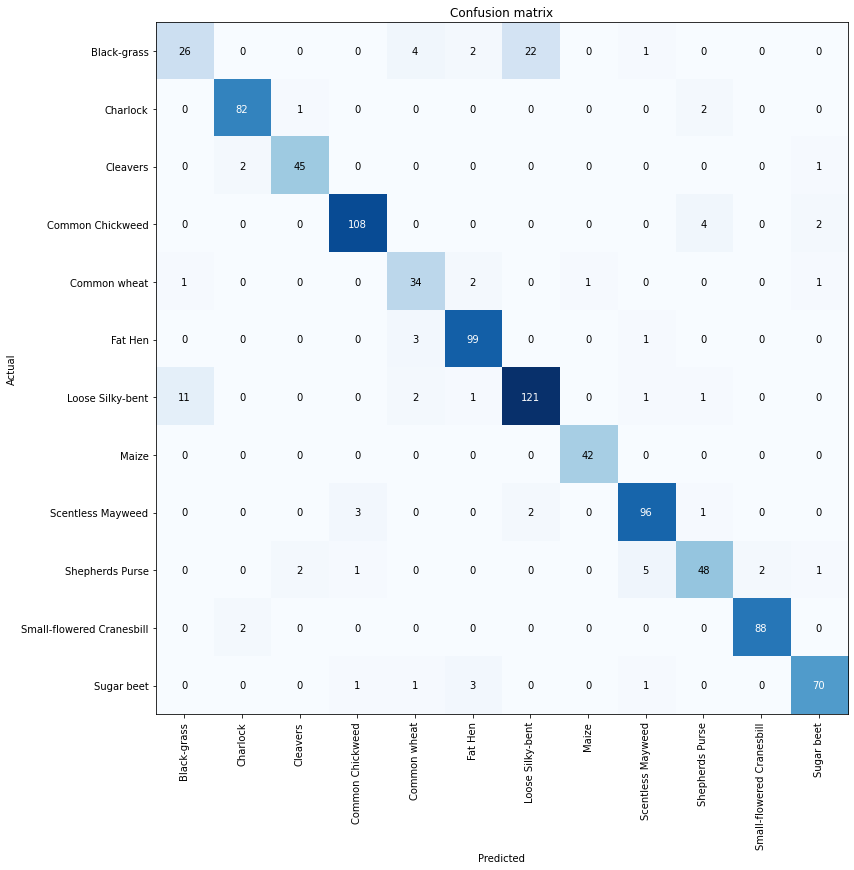

In [12]:
interp.plot_confusion_matrix(figsize = (15, 12))

In [13]:
interp.most_confused(min_val=3)

[('Black-grass', 'Loose Silky-bent', 22),
 ('Loose Silky-bent', 'Black-grass', 11),
 ('Shepherds Purse', 'Scentless Mayweed', 5),
 ('Black-grass', 'Common wheat', 4),
 ('Common Chickweed', 'Shepherds Purse', 4),
 ('Fat Hen', 'Common wheat', 3),
 ('Scentless Mayweed', 'Common Chickweed', 3),
 ('Sugar beet', 'Fat Hen', 3)]

In [14]:
learn.load('resnet34_1')

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,0.479186,4.929116,0.424211,01:04
1,0.559008,0.390366,0.865263,01:04
2,0.417599,0.374569,0.858947,01:04
3,0.285752,0.238821,0.932632,01:04
4,0.182342,0.133825,0.954737,01:04
5,0.116005,0.117099,0.951579,01:04


In [19]:
learn.load('resnet34_1')

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=6.309573450380412e-07)

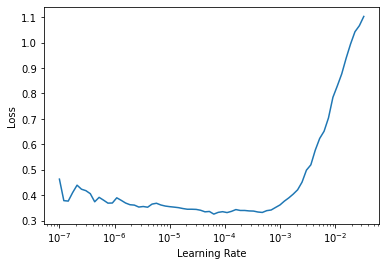

In [20]:
learn.lr_find()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.313640,0.248867,0.914737,01:05
1,0.303095,0.219871,0.922105,01:04
2,0.236249,0.194435,0.933684,01:05
3,0.185275,0.179702,0.937895,01:05
4,0.131517,0.175935,0.941053,01:05
5,0.119148,0.175174,0.941053,01:05


In [22]:
learn.save('resnet34_2')

In [23]:
learn.load('resnet34_1')
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.345211,0.251014,0.918947,01:05
1,0.302142,0.239195,0.921053,01:05
2,0.238788,0.215677,0.926316,01:05
3,0.169788,0.170891,0.942105,01:05
4,0.106722,0.136662,0.952632,01:05
5,0.081444,0.143052,0.953684,01:05


In [24]:
learn.save("resnet34_3")#This model gives higher accuracy 

In [25]:
test_path = Path('/content/data/test')

In [26]:
test_img = get_image_files(test_path)

In [27]:
test_dls = learn.dls.test_dl(test_img)

In [28]:
preds, _ = learn.get_preds(dl=test_dls)

In [29]:
preds.shape

torch.Size([794, 12])

In [30]:
thresh = 0.2
labelled_preds = [' '.join([learn.dls.vocab[i] for i,
                p in enumerate(pred) if p > thresh]) 
                for pred in preds.numpy()]

In [ ]:
# labelled_preds[:]

In [31]:
fnames = [f.name for f in test_img]

In [32]:
df = pd.DataFrame({'file':fnames, 'species':labelled_preds}, columns=['file', 'species'])

In [33]:
df.head()

,file,species
0,b3d6fdb80.png,Shepherds Purse
1,32a8c8a1d.png,Loose Silky-bent
2,bb1c84bbc.png,Loose Silky-bent
3,75cb95e91.png,Charlock
4,bb64660b7.png,Sugar beet


In [34]:
df.to_csv('/content/data/mysubmission.csv', index=False)

In [35]:
learn.load('resnet34_2')
preds, _ = learn.get_preds(dl=test_dls)
thresh = 0.2
labelled_preds = [' '.join([learn.dls.vocab[i] for i,
                p in enumerate(pred) if p > thresh]) 
                for pred in preds.numpy()]
fnames = [f.name for f in test_img]
df = pd.DataFrame({'file':fnames, 'species':labelled_preds}, columns=['file', 'species'])
df.head()

,file,species
0,b3d6fdb80.png,Shepherds Purse
1,32a8c8a1d.png,Loose Silky-bent
2,bb1c84bbc.png,Loose Silky-bent
3,75cb95e91.png,Charlock
4,bb64660b7.png,Sugar beet


In [36]:
df.to_csv('/content/data/mysubmission1.csv', index=False)

In [37]:
learn.load('resnet34_1')
preds, _ = learn.get_preds(dl=test_dls)
thresh = 0.2
labelled_preds = [' '.join([learn.dls.vocab[i] for i,
                p in enumerate(pred) if p > thresh]) 
                for pred in preds.numpy()]
fnames = [f.name for f in test_img]
df = pd.DataFrame({'file':fnames, 'species':labelled_preds}, columns=['file', 'species'])
df.head()

,file,species
0,b3d6fdb80.png,Shepherds Purse
1,32a8c8a1d.png,Loose Silky-bent
2,bb1c84bbc.png,Loose Silky-bent
3,75cb95e91.png,Charlock
4,bb64660b7.png,Sugar beet


In [38]:
df.to_csv('/content/data/mysubmission2.csv', index=False)